In [14]:
import os
import cv2
import numpy as np
from tqdm import tqdm


REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "dog-vs-cats/train/cat"
    DOGS = "dog-vs-cats/train/dog"
    TESTING = "dog-vs-cats/test1"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
   
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
  





  0%|          | 46/12500 [00:00<00:27, 455.87it/s]

dog-vs-cats/train/cat


  1%|          | 68/12500 [00:00<00:18, 676.74it/s]

dog-vs-cats/train/dog


100%|██████████| 12500/12500 [00:23<00:00, 537.16it/s]


Cats: 12500
Dogs: 12500


In [20]:
training_data = np.load("training_data.npy",allow_pickle = True)
print(dogsvcats.dogcount)
print(dogsvcats.catcount)

12500
12500


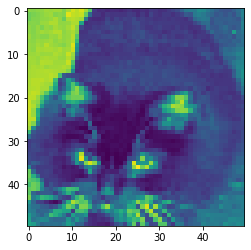

In [21]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0])
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [23]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])


VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)


train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

2500
22500 2500


In [ ]:
BATCH_SIZE = 100
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")
    

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.2033715844154358


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.18622271716594696


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.16712699830532074


 37%|███▋      | 84/225 [00:55<01:35,  1.48it/s]

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2500/2500 [00:11<00:00, 219.99it/s]

Accuracy:  0.647
